# Exercise 2: Implement structured pruning on a small language model with Hugging Face Transformers

Neural network pruning is a powerful technique to reduce model size and improve inference performance. In this exercise, you'll apply structured pruning to a pre-trained language model using the Hugging Face Transformers library.

> **Task**: Implement structured attention head pruning on a pre-trained DistilBERT model to remove 30% of the least important heads while monitoring the accuracy-efficiency tradeoff.
> 
> **Goal**: By the end of this exercise, you'll understand how to identify redundant attention heads, implement structured pruning without specialized libraries, and evaluate the resulting model's performance.
> 
> **Scenario**: You're developing a customer feedback analysis system for a retail chain. The system processes product reviews and social media mentions to extract sentiment in real-time across thousands of stores. Your current DistilBERT model (fine-tuned on SST-2) performs excellently but consumes too much memory and compute for your distributed edge servers.
> <br> The initial model works great on movie reviews (SST-2's domain) and transfers well to product reviews. However, deploying it to every store location would require expensive hardware upgrades. Since the model already achieves 91% accuracy—more than sufficient for business insights—you've chosen structured pruning to trade a small amount of accuracy for significant efficiency gains.
> 
> **Tools**: pytorch, transformers, numpy, pandas, matplotlib
> <br> Prior experience recommended!
> 
> **Estimated Time**: ~=15 minutes

## Step 1: Setup

First, let's import the necessary libraries:

In [1]:
# # Uncomment to install necessary libraries, then comment out the cell block again and restart the notebook
# ! pip install transformers

In [2]:
# Import libraries
from pprint import pprint
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TextClassificationPipeline
from datasets import load_dataset

# Suppress warnings
warnings.filterwarnings("ignore")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up plotting
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Set the device for pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Libraries imported successfully!")

/home/student/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!


## Step 2: Load a pre-trained model and dataset

We'll use a small BERT model (`distilbert-base-uncased`) fine-tuned for sentiment analysis. This model is relatively compact but still demonstrates the benefits of pruning.

In [3]:
# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move to GPU if available
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"Model: {model_name}")
print(f"Device: {device}")

# Load a small test dataset (SST-2)
test_dataset = load_dataset("glue", "sst2", split="validation[:500]")
print(f"Test dataset loaded: {len(test_dataset)} examples")

Model: distilbert-base-uncased-finetuned-sst-2-english
Device: cuda
Test dataset loaded: 500 examples


> **Why DistilBERT with the Stanford Sentiment Treebank (SST-2) dataset?**: We're using DistilBERT for this exercise because:
> 
> - It's already a compressed version of BERT (using knowledge distillation)
> - It has a simpler architecture than full BERT but retains the key transformer components
> - It's pre-trained and fine-tuned for sentiment analysis on SST-2, making evaluation straightforward
> 
> The Stanford Sentiment Treebank (SST-2) dataset contains movie review sentences with binary sentiment labels (positive/negative), making it perfect for evaluating our pruned model's performance.

# Step 3: Analyze the model's architecture

Let's first understand the structure of our model and calculate basic metrics like parameter count and model size.

In [4]:
# TODO: Calculate total parameters in the model
# Hint: Not sure how to inspect model layers or count parameters?
# See: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
# and: https://discuss.pytorch.org/t/how-do-i-count-the-number-of-parameters-in-a-model/4325
total_params = sum(p.numel() for p in model.parameters())

# TODO: Calculate trainable parameters
# Hint: Parameters have an attribute indicating if they require gradients
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# TODO: Calculate model size in MB (assuming 32-bit float - 4 bytes per parameter)
# Hint: Convert from bytes to megabytes using the appropriate divisor
model_size_mb = total_params * 4 / (1024 * 1024)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size (MB): {model_size_mb:.2f}")

# Count attention heads
def count_attention_heads(model):
    """Count total attention heads in a transformer model."""
    total_heads = 0
    for module in model.modules():
        # TODO: Define if a module is an attention head
        # Hint: You can check modules' attributes at runtime using `module.__dict__` or `print(module)`
        is_attention_module = hasattr(module, 'n_heads')
        # Check for attention modules in the model
        if is_attention_module:
            total_heads += module.n_heads
    return total_heads

print(f"Total attention heads in the model: {count_attention_heads(model)}")

Total parameters: 66,955,010
Trainable parameters: 66,955,010
Model size (MB): 255.41
Total attention heads in the model: 72


> **Understanding the model architecture**: DistilBERT has a simpler architecture than BERT:
> 
> 6 transformer layers (vs. 12 in BERT-base)
> 12 attention heads per layer (same as BERT-base)
> 768 hidden dimensions (same as BERT-base)
> 
> Each attention head processes information differently, capturing various linguistic patterns and relationships. However, not all heads contribute equally to the model's performance. By identifying and removing the least important heads, we can reduce model size and inference time while maintaining most of the accuracy.

# Step 4: Create evaluation pipeline

Before we start pruning, we need a way to evaluate our model's performance. Let's create a function that measures accuracy, latency, and model size.

In [5]:
def evaluate_model(model, tokenizer, dataset, device, num_samples=100, batch_size=16):
    """Evaluate model accuracy and latency on a dataset."""
    # Move model to evaluation mode
    model.eval()
    
    # Create pipeline
    pipeline = TextClassificationPipeline(
        model=model, 
        tokenizer=tokenizer,
        device=device if device.type != "cpu" else -1,
        return_all_scores=True
    )
    
    # Prepare inputs
    texts = dataset["sentence"][:num_samples]
    labels = dataset["label"][:num_samples]
    
    # Measure accuracy
    correct = 0
    latencies = []
    
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            
            # Measure inference time
            start_time = time.time()
            outputs = pipeline(batch_texts)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            end_time = time.time()
            
            latency = (end_time - start_time) * 1000  # Convert to ms
            latencies.append(latency)
            
            # Calculate accuracy
            for j, output in enumerate(outputs):
                pred_label = 0 if output[0]["score"] > output[1]["score"] else 1
                if pred_label == batch_labels[j]:
                    correct += 1
    
    accuracy = correct / num_samples
    avg_latency = np.mean(latencies) / batch_size  # Latency per example
    
    # TODO: Calculate model size in MB
    # Hint: You need to calculate the model size, but then you can reuse the same logic as in Step 3 to move to MB
    model_size = sum(p.nelement() * p.element_size() for p in model.parameters()) / (1024 * 1024)
    
    return {
        "accuracy": accuracy,
        "avg_latency_ms": avg_latency,
        "model_size_mb": model_size
    }

# Evaluate original model
print("Evaluating original model...")
original_metrics = evaluate_model(model, tokenizer, test_dataset, device)

print(f"Original model metrics:")
print(f"- Accuracy: {original_metrics['accuracy']:.4f}")
print(f"- Avg Latency: {original_metrics['avg_latency_ms']:.2f} ms")
print(f"- Model Size: {original_metrics['model_size_mb']:.2f} MB")

Device set to use cuda


Evaluating original model...
Original model metrics:
- Accuracy: 0.9400
- Avg Latency: 7.64 ms
- Model Size: 255.41 MB


> **Brainstorming check!**
> <br>
> What other metrics would you track?

## Step 5: Implement structured attention head pruning

Now we'll implement the core of our exercise: structured pruning of attention heads in a transformer model. This is a multi-step process that involves:

1. Identifying which attention heads are least important
2. Creating a mechanism to measure head importance
3. Selecting heads for pruning

In [6]:
# Function to analyze attention head importance
def analyze_head_importance(model, tokenizer, dataset, device, num_samples=50):
    """Analyze the importance of each attention head."""
    head_importance = {}
    model.eval()
    
    # Get attention modules
    attention_modules = []
    for name, module in model.named_modules():
        # TODO: Define if a module is an attention head
        # Hint: You can reuse the same logic as in Step 3.
        is_attention_module = hasattr(module, 'n_heads')
        if is_attention_module:
            attention_modules.append((name, module))
    
    # Sample some data
    inputs = tokenizer(dataset["sentence"][:num_samples], 
                       padding=True, 
                       truncation=True, 
                       return_tensors="pt").to(device)
    
    # Get baseline outputs
    with torch.no_grad():
        baseline_outputs = model(**inputs).logits
        baseline_probs = torch.softmax(baseline_outputs, dim=1)
    
    # For each attention module and head
    for module_name, module in attention_modules:
        head_importance[module_name] = []
        
        # For each head in this module
        for head_idx in range(module.n_heads):
            # Mask a specific attention head and measure its impact
            def mask_head(module, inputs, head_idx=head_idx):
                # Store the original attention output
                original_func = module.forward
                
                # Define a new forward function that masks a specific head
                def masked_forward(*args, **kwargs):
                    outputs = original_func(*args, **kwargs)
                    # Mask the attention scores for this head
                    if isinstance(outputs, tuple):
                        attn_output = outputs[0]
                        head_size = attn_output.size(-1) // module.n_heads
                        # TODO: Create indices to zero out for this specific head
                        # Hint: Each head occupies a contiguous block of size `head_size` in the last dimension.
                        # Calculate the start and end index for the block belonging to `head_idx`, and pass it to torch.arange() with the right device
                        indices = torch.arange(head_size * head_idx, head_size * (head_idx + 1), 
                                              device=attn_output.device)
                        attn_output[:, :, indices] = 0
                        return outputs
                    return outputs
                
                # Replace the forward method
                module.forward = masked_forward
                
                # Run the model
                with torch.no_grad():
                    masked_outputs = model(**inputs).logits
                    masked_probs = torch.softmax(masked_outputs, dim=1)
                
                # Restore the original forward method
                module.forward = original_func
                
                return masked_probs
            
            # Run the model with this head masked
            masked_probs = mask_head(module, inputs)
            
            # TODO: Calculate head importance as the difference in output when the head is masked
            # Hint: Consider how to measure the difference between two probability distributions
            prob_diff = torch.abs(masked_probs - baseline_probs).mean().item()
            head_importance[module_name].append(prob_diff)
    
    print(f"Analysis completed.")
    return head_importance

# Analyze head importance
print("Analyzing attention head importance...")
head_importance = analyze_head_importance(model, tokenizer, test_dataset, device)
pprint(head_importance)

Analyzing attention head importance...
Analysis completed.
{'distilbert.transformer.layer.0.attention': [0.0020249898079782724,
                                              0.01334353070706129,
                                              0.0020759522449225187,
                                              0.0016341600567102432,
                                              0.004370659124106169,
                                              0.0015352156478911638,
                                              0.001514639938250184,
                                              0.002063632942736149,
                                              0.0019017091253772378,
                                              0.0014550309861078858,
                                              0.0022707744501531124,
                                              0.0009598431061021984],
 'distilbert.transformer.layer.1.attention': [0.003669423284009099,
                                              0.0

> **How does head importance work?**: The technique we're using is called masking-based importance scoring. Here's how it works:
> 
> 1. We run the model normally to get baseline predictions
> 2. For each attention head, we temporarily modify the model to mask (zero out) that head's output
> 3. We compare the new predictions with the baseline
> 4. The larger the difference, the more important the head is
> 
> This is a form of ablation analysis - we're measuring the impact of removing a component. Heads with minimal impact on the output are good candidates for pruning.
> 
> The method is computationally efficient because we only need to run inference, not training or fine-tuning.

## Step 6: Visualize head importance and select heads for pruning

Now that we've computed importance scores for each attention head, let's visualize the results and select which heads to prune.

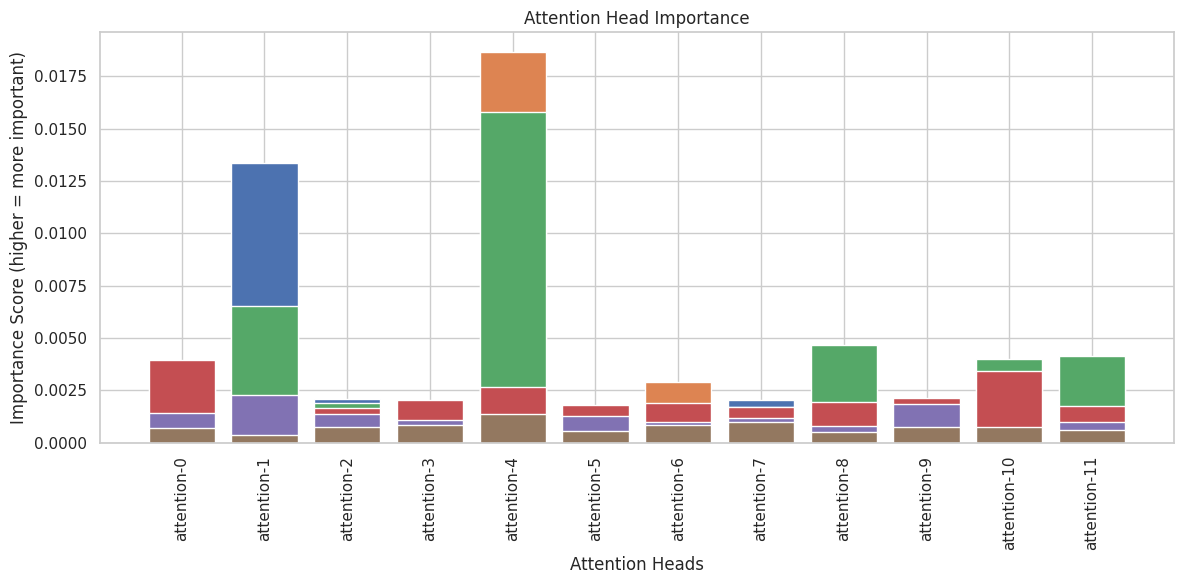

Pruning 21 heads with lowest importance scores
Pruning distilbert.transformer.layer.5.attention head 1 (importance: 0.000367)
Pruning distilbert.transformer.layer.5.attention head 8 (importance: 0.000498)
Pruning distilbert.transformer.layer.5.attention head 5 (importance: 0.000564)
Pruning distilbert.transformer.layer.5.attention head 11 (importance: 0.000607)
Pruning distilbert.transformer.layer.4.attention head 10 (importance: 0.000686)
Pruning distilbert.transformer.layer.5.attention head 0 (importance: 0.000723)
Pruning distilbert.transformer.layer.5.attention head 10 (importance: 0.000744)
Pruning distilbert.transformer.layer.5.attention head 9 (importance: 0.000758)
Pruning distilbert.transformer.layer.5.attention head 2 (importance: 0.000760)
Pruning distilbert.transformer.layer.4.attention head 8 (importance: 0.000801)
Pruning distilbert.transformer.layer.4.attention head 4 (importance: 0.000829)
Pruning distilbert.transformer.layer.5.attention head 6 (importance: 0.000841)
Pr

In [8]:
# Visualize head importance
plt.figure(figsize=(12, 6))
for module_name, importances in head_importance.items():
    module_name = module_name.split('.')[-1]  # Shorten the name
    plt.bar(
        [f"{module_name}-{i}" for i in range(len(importances))],
        importances
    )
plt.xticks(rotation=90)
plt.title("Attention Head Importance")
plt.xlabel("Attention Heads")
plt.ylabel("Importance Score (higher = more important)")
plt.tight_layout()
plt.show()

# TODO: Determine how many heads to prune based on a pruning rate
# Hint: Consider what percentage of heads you want to remove
pruning_rate = 0.3  # 30% of heads will be pruned

# TODO: Calculate the number of heads to prune based on the pruning rate
# Hint: Count the total number of heads and apply the rate
n_heads_to_prune = int(sum(len(imp) for imp in head_importance.values()) * pruning_rate)

# Flatten and sort all heads by importance
all_heads = []
for module_name, importances in head_importance.items():
    for i, imp in enumerate(importances):
        all_heads.append((module_name, i, imp))

# TODO: Sort heads by importance to identify which to prune first
# Hint: Each item is a tuple of (module_name, head_idx, importance). Also, should you prune in ascending or descending order?
# Finally, feel free to sort in place instead!
all_heads.sort(key=lambda item: item[2])

# Get the least important heads
heads_to_prune = all_heads[:n_heads_to_prune]
print(f"Pruning {len(heads_to_prune)} heads with lowest importance scores")

# Print the heads to be pruned
for module_name, head_idx, imp in heads_to_prune:
    print(f"Pruning {module_name} head {head_idx} (importance: {imp:.6f})")

> **Interpreting the visualization**: The bar chart shows the importance score for each attention head across all layers. You should notice:
> 
> 1. Varying Importance: Some heads have much higher scores than others
> 2. Layer Patterns: Heads in certain layers may be systematically more important
> 3. Redundancy: Many heads have very low importance scores
> 
> This uneven distribution confirms our hypothesis that not all attention heads contribute equally to the model's performance. By pruning the least important heads (those with the lowest bars), we can reduce model complexity while minimizing impact on accuracy.

# Step 7: Implement head pruning

Now that we've identified which attention heads to prune, let's implement the actual pruning operation. This involves modifying the model architecture to remove the selected heads.

In [9]:
def prune_heads_in_model(model, heads_to_prune):
    """Prune attention heads in the model using Hugging Face's built-in method."""
    # Format the heads to prune into a dictionary that matches HuggingFace's format
    # {layer_num: [list of heads to prune in this layer]}
    pruning_dict = {}
    
    # Create a dictionary of heads to prune by layer index
    for module_name, head_idx, _ in heads_to_prune:
        # Extract layer index from module name (e.g., 'transformer.layer.0.attention')
        layer_parts = module_name.split('.')
        for i, part in enumerate(layer_parts):
            if part == 'layer' and i+1 < len(layer_parts) and layer_parts[i+1].isdigit():
                layer_idx = int(layer_parts[i+1])
                
                # TODO: Update the pruning dictionary for this layer for pruning
                # Hint: The expected output is a list. What would an empty list represent here?
                if layer_idx not in pruning_dict:
                    pruning_dict[layer_idx] = []
                pruning_dict[layer_idx].append(head_idx)
                break
    
    # Print the pruning plan
    print("Pruning plan:")
    for layer_idx, heads in pruning_dict.items():
        print(f"Layer {layer_idx}: Pruning heads {heads}")
    
    # Clone the model to avoid modifying the original
    pruned_model = type(model)(model.config)
    pruned_model.load_state_dict(model.state_dict())
    pruned_model = pruned_model.to(device)
    
    # Perform pruning layer by layer
    for layer_idx, heads in pruning_dict.items():
        # Find the attention module for this layer
        attention_module = None
        for name, module in pruned_model.named_modules():
            if f'layer.{layer_idx}.attention' in name and hasattr(module, 'prune_heads'):
                attention_module = module
                break
        
        if attention_module is not None:
            # TODO: Prune the defined attention heads for the module
            # Hint: Hugging Face provides a built-in functionality that updated attention_module in place!
            # See: https://huggingface.co/docs/transformers/main/main_classes/model
            # Add your one-line code here
            attention_module.prune_heads(heads)
        else:
            print(f"Warning: Could not find attention module for layer {layer_idx}")
    
    return pruned_model

# Prune the model
pruned_model = prune_heads_in_model(model, heads_to_prune)

Pruning plan:
Layer 5: Pruning heads [1, 8, 5, 11, 0, 10, 9, 2, 6, 3, 7]
Layer 4: Pruning heads [10, 8, 4, 11, 6, 3, 7]
Layer 1: Pruning heads [7, 2]
Layer 0: Pruning heads [11]


> **Understanding the structured pruning implementation**: This implementation of structured pruning has several key components:
> 
> - Weight Masking: We create boolean masks to select which weights to keep and which to discard
> - Architecture Modification: We actually change the structure of the model by removing rows/columns from weight matrices
> - Metadata Updates: We update the model's metadata (like number of heads) to reflect the new architecture
> 
> Unlike unstructured pruning which simply zeros out weights, structured pruning creates a truly smaller model with fewer parameters. This results in actual memory savings and computational speedups on standard hardware.

# Step 8: Evaluate and compare models

Now let's apply our pruning function and evaluate the pruned model's performance compared to the original.

In [10]:
# Evaluate pruned model
print("Evaluating pruned model...")
pruned_metrics = evaluate_model(pruned_model, tokenizer, test_dataset, device)

print(f"Pruned model metrics:")
print(f"- Accuracy: {pruned_metrics['accuracy']:.4f}")
print(f"- Avg Latency: {pruned_metrics['avg_latency_ms']:.2f} ms")
print(f"- Model Size: {pruned_metrics['model_size_mb']:.2f} MB")

# Compare before and after pruning
print("\nComparison:")
print(f"Accuracy change: {(pruned_metrics['accuracy'] - original_metrics['accuracy']) * 100:.2f}%")
print(f"Latency improvement: {(1 - pruned_metrics['avg_latency_ms'] / original_metrics['avg_latency_ms']) * 100:.2f}%")
print(f"Size reduction: {(1 - pruned_metrics['model_size_mb'] / original_metrics['model_size_mb']) * 100:.2f}%")

Device set to use cuda


Evaluating pruned model...
Pruned model metrics:
- Accuracy: 0.8900
- Avg Latency: 5.74 ms
- Model Size: 239.65 MB

Comparison:
Accuracy change: -5.00%
Latency improvement: 24.89%
Size reduction: 6.17%


> **Interpreting the results**: After pruning, you should observe:
> 
> 1. Model Size Reduction: The pruned model should be smaller than the original
> 2. Latency Improvement: Inference should be faster with fewer attention heads
> 3. Accuracy Impact: There may be a small decrease in accuracy
> 
> _The key question is:_ Does the trade-off make sense for your use case?
> 
> - For mobile deployment, size reduction might be the priority
> - For real-time applications, latency improvement might be most important
> - For critical applications, maintaining accuracy might be non-negotiable

# Step 9: Test with real-world examples

Let's test our pruned model on some example sentences to verify it still works well in practice.

In [11]:
# Function to test sentiment analysis
def test_sentiment(model, tokenizer, sentences):
    """Test sentiment analysis on example sentences."""
    model.eval()
    pipeline = TextClassificationPipeline(
        model=model,
        tokenizer=tokenizer,
        device=device if device.type != "cpu" else -1
    )
    
    results = []
    for sentence in sentences:
        result = pipeline(sentence)
        label = result[0]['label']
        score = result[0]['score']
        results.append((sentence, label, score))
    
    return results

# Test with some examples
test_sentences = [
    "I really loved this movie, it was fantastic!",
    "The food was mediocre at best.",
    "This book changed my life in many positive ways.",
    "I'm feeling extremely disappointed with the service provided."
]

print("\nTesting original model:")
original_results = test_sentiment(model, tokenizer, test_sentences)
for sentence, label, score in original_results:
    print(f"'{sentence}' -> {label} ({score:.4f})")

print("\nTesting pruned model:")
pruned_results = test_sentiment(pruned_model, tokenizer, test_sentences)
for sentence, label, score in pruned_results:
    print(f"'{sentence}' -> {label} ({score:.4f})")

Device set to use cuda
Device set to use cuda



Testing original model:
'I really loved this movie, it was fantastic!' -> POSITIVE (0.9999)
'The food was mediocre at best.' -> NEGATIVE (0.9996)
'This book changed my life in many positive ways.' -> POSITIVE (0.9998)
'I'm feeling extremely disappointed with the service provided.' -> NEGATIVE (0.9998)

Testing pruned model:
'I really loved this movie, it was fantastic!' -> POSITIVE (0.9987)
'The food was mediocre at best.' -> NEGATIVE (0.9778)
'This book changed my life in many positive ways.' -> POSITIVE (0.9955)
'I'm feeling extremely disappointed with the service provided.' -> NEGATIVE (0.9764)


> **From theory to practice**: Testing the pruned model on real examples is crucial to ensure that:
> 
> 1. The model still produces correct classifications for obvious cases
> 2. The confidence scores remain reasonable (not all 0.5 or all 1.0)
> 3. The model handles different sentence styles and topics appropriately
> 
> If the model's real-world performance is acceptable after pruning, it validates our approach. If not, we might need to:
> 
> - Try a less aggressive pruning ratio
> - Consider fine-tuning after pruning
> - Experiment with alternative pruning criteri

## Conclusion

In this exercise, you've learned how to:

- Analyze attention head importance in transformer models using masking-based techniques
- Implement structured pruning to remove redundant attention heads
- Evaluate the performance impact of pruning
- Make informed decisions about the accuracy-efficiency tradeoff

These skills allow you to optimize transformer models for deployment in resource-constrained environments without retraining from scratch. Structured pruning is particularly valuable because it creates truly smaller models that run efficiently on standard hardware.